In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import os
import re
import sys
import pyBigWig
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from typing import Union, Optional
from torch.utils.data import Dataset, DataLoader

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_job_folder, get_bioqueue_job_info, get_bioqueue_file, Reds

In [ ]:
class EvaluationDataset(Dataset):
    def __init__(
        self,
        pl_pred_bw_file: str,
        pl_obs_bw_file: str,
        peak_file: Union[str, pd.DataFrame],
        mn_pred_bw_file: Optional[str] = None,
        mn_obs_bw_file: Optional[str] = None,
        unified_len_def: int = 1000,
        all_regions: bool = False,
    ):
        """
        Initialize the dataset.

        Parameters
        ----------
        pl_pred_bw_file : str
            Path to the bigwig file storing predictions for the forward (+) strand.
        pl_obs_bw_file : str
            Path to the bigwig file storing ground truth for the forward (+) strand.
        peak_file : str or pandas.DataFrame
            Path to a headless CSV file storing the regions of interest, or an
            in-memory dataframe with equivalent information.
        mn_pred_bw_file : str, optional
            Path to the bigwig file storing predictions for the reverse (-) strand.
            If None, reverse-strand predictions are not used. Default is None.
        mn_obs_bw_file : str, optional
            Path to the bigwig file storing ground truth for the reverse (-) strand.
            If None, reverse-strand ground truth is not used. Default is None.
        unified_len_def : int, optional
            Target length (in base pairs) to which region spans are extended or
            trimmed. Default is 1000.
        all_regions : bool, optional
            Whether to include all regions provided in ``peak_file``. If False,
            a subset of regions may be selected (for example after filtering or
            subsampling). Default is False.
        """
        if any([not os.path.exists(f) for f in (
                pl_pred_bw_file, pl_obs_bw_file)]):
            raise IOError()
        self.pl_pred_bw = pyBigWig.open(pl_pred_bw_file)
        self.pl_obs_bw = pyBigWig.open(pl_obs_bw_file)
        self._in_files = [pl_pred_bw_file, pl_obs_bw_file, mn_pred_bw_file, mn_obs_bw_file]
        
        if all([f is not None and os.path.exists(f) for f in (
                mn_pred_bw_file, mn_obs_bw_file)]):
            self.mn_pred_bw = pyBigWig.open(mn_pred_bw_file)
            self.mn_obs_bw = pyBigWig.open(mn_obs_bw_file)
        else:
            self.mn_pred_bw = None
            self.mn_obs_bw = None
            print("No signal tracks for the reverse strands.")

        if isinstance(peak_file, str):
            self.regions = pd.read_csv(peak_file, header=None, comment="#")
        else:
            self.regions = peak_file.copy()
        if not all_regions:
            self.regions = self.regions.loc[self.regions[3] == 1].reset_index(drop=True)
        allowed_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", ]
        self.regions = self.regions.loc[self.regions[0].isin(allowed_chroms)].reset_index(drop=True)

        half = unified_len_def // 2
        mids = (self.regions[1] + self.regions[2]) // 2
        self.regions[1] = mids - half
        self.regions[2] = mids + half

        self._warns = 0

    def __len__(self):
        return self.regions.shape[0]

    def bw_retriever(self, bw_in, chrom, start, end, bw_idx = None):
        try:
            return np.abs(np.nan_to_num(bw_in.values(chrom, start, end)))
        except Exception:
            if bw_idx is not None:
                bw_info = self._in_files[bw_idx]
            else:
                bw_info = str(bw_in)
            self._warns += 1
            if self._warns < 3:
                print(f"Warning: No values stored in {bw_info} for region {chrom}:{start}-{end}")
            return np.zeros(end - start)

    def __getitem__(self, idx: int):
        try:
            y_hats = []
            y = []
            have_mn = False
            hit = self.regions.iloc[idx]
            
            y_hat_pl = self.bw_retriever(self.pl_pred_bw, hit[0], hit[1], hit[2], 0)
            y_pl = self.bw_retriever(self.pl_obs_bw, hit[0], hit[1], hit[2], 1)

            if self.mn_pred_bw is not None and self.mn_obs_bw is not None:
                y_hat_mn = self.bw_retriever(self.mn_pred_bw, hit[0], hit[1], hit[2], 2)
                y_mn = self.bw_retriever(self.mn_obs_bw, hit[0], hit[1], hit[2], 3)
                have_mn = True

            y_hats.append(y_hat_pl)
            y.append(y_pl)

            if have_mn:
                y_hats.append(y_hat_mn)
                y.append(y_mn)
        except Exception as e:
            print(hit, self._in_files)
            raise e

        return torch.from_numpy(np.stack(y_hats)), torch.from_numpy(np.stack(y))
    def close_files(self):
        self.pl_pred_bw.close()
        self.pl_obs_bw.close()
        if self.mn_pred_bw is not None:
            self.mn_pred_bw.close()
        if self.mn_obs_bw is not None:
            self.mn_obs_bw.close()

In [ ]:
def get_ref_files(lst: list[str], pattern: str) -> list[str]:
    """
    Resolve existing reference file paths from job strings.

    Parameters
    ----------
    lst : list of str
        Strings to parse.
    pattern : str
        Regex with two capturing groups: job identifier and file name.

    Returns
    -------
    list of str
        Existing file paths derived from the matches.

    Raises
    ------
    ValueError
        If any string does not match ``pattern``.
    IOError
        If a resolved file path does not exist.
    """
    matches = []
    for item in lst:
        match = re.match(pattern, item)
        if match:
            group1 = match.group(1)
            group2 = match.group(2)
            job_folder = get_bioqueue_job_folder(group1)
            job_file = os.path.join(job_folder, group2)
            if not os.path.exists(job_file):
                raise IOError(f"{job_file} doesn't exist!")
            matches.append(job_file)
        else:
            raise ValueError(f"{item} doesn't match the expected pattern.")
    return matches

In [ ]:
def evaluate_corr(
    peak_file: Union[str, pd.DataFrame],
    r1_pl: str,
    r1_mn: str,
    r2_pl: str,
    r2_mn: str,
    assay_name: str,
    cellline_name: str,
    all_regions: bool = False,
) -> pd.DataFrame:
    """
    Compute observed and predicted summit positions for each region.

    Parameters
    ----------
    peak_file : str or pandas.DataFrame
        Regions of interest, either as a path to a file or an in-memory
        dataframe.
    r1_pl : str
        Path to the bigwig file with predicted signal on the forward strand.
    r1_mn : str
        Path to the bigwig file with predicted signal on the reverse strand.
    r2_pl : str
        Path to the bigwig file with observed signal on the forward strand.
    r2_mn : str
        Path to the bigwig file with observed signal on the reverse strand.
    assay_name : str
        Name of the assay used for annotation in the output.
    cellline_name : str
        Name of the cell line used for annotation in the output.
    all_regions : bool, optional
        Whether to include all regions from ``peak_file``. Default is False.

    Returns
    -------
    pandas.DataFrame
        Dataframe with observed summit positions, predicted summit positions,
        and metadata columns ``"Assay"`` and ``"Cell"``.
    """
    evaluation_dataset = EvaluationDataset(
        pl_pred_bw_file=r1_pl, mn_pred_bw_file=r1_mn, 
        pl_obs_bw_file=r2_pl, mn_obs_bw_file=r2_mn, 
        peak_file=peak_file, 
        all_regions=all_regions)

    # obs_summits = np.zeros(len(evaluation_dataset) * n_strand)
    obs_summits = []
    pred_summits = []  # np.zeros_like(obs_summits)
    _iter = DataLoader(evaluation_dataset, batch_size=32, shuffle=False, num_workers=0)
    last = 0
    for ds in _iter:
        # shape
        y_hat = ds[0]
        y = ds[1]
        y_loc = y.argmax(axis=-1).flatten()
        y_max = y.max(dim=-1)[0].flatten()
        probe = y_max > 10
        y_loc = y_loc[probe]
        n_vals = len(y_loc)
        obs_summits.extend(y_loc.tolist())
        y_hat_loc = y_hat.argmax(axis=-1).flatten()
        y_hat_loc = y_hat_loc[probe]
        pred_summits.extend(y_hat_loc.tolist())
        last += n_vals
    evaluation_dataset.close_files()
    df = pd.DataFrame((np.asarray(obs_summits), np.asarray(pred_summits))).T
    df["Assay"] = assay_name
    df["Cell"] = cellline_name
    return df

In [7]:
initiation_region_file_job_mapping = {
    "K562": 7177, 
    "A673": 7177, 
    "HCT116": 7177, 
    "HUVEC": 7177, 
    "MCF10A": 7177, 
    "Caco2": 7178, 
    "Calu3": 7178, 
    "GM12878": 7178, 
    "LNCaP": 7178, 
    "MCF7": 7178,
}

In [8]:
deepdetails_5d_init_job_mapping = {
    "5D1_A673_Initiation": (
        get_bioqueue_file("{{History:15837-a673.pl.bw}}"),
        get_bioqueue_file("{{History:15837-a673.mn.bw}}")
    ),
    "5D1_HCT116_Initiation": (
        get_bioqueue_file("{{History:15837-hct116.pl.bw}}"),
        get_bioqueue_file("{{History:15837-hct116.mn.bw}}")
    ),
    "5D1_HUVEC_Initiation": (
        get_bioqueue_file("{{History:15837-huvec.pl.bw}}"),
        get_bioqueue_file("{{History:15837-huvec.mn.bw}}")
    ),
    "5D1_K562_Initiation": (
        get_bioqueue_file("{{History:15837-k562.pl.bw}}"),
        get_bioqueue_file("{{History:15837-k562.mn.bw}}")
    ),
    "5D1_MCF10A_Initiation": (
        get_bioqueue_file("{{History:15837-mcf10a.pl.bw}}"),
        get_bioqueue_file("{{History:15837-mcf10a.mn.bw}}")
    ),
    "5D2_Caco2_Initiation": (
        get_bioqueue_file("{{History:15838-caco2.pl.bw}}"),
        get_bioqueue_file("{{History:15838-caco2.mn.bw}}")
    ),
    "5D2_Calu3_Initiation": (
        get_bioqueue_file("{{History:15838-calu3.pl.bw}}"),
        get_bioqueue_file("{{History:15838-calu3.mn.bw}}")
    ),
    "5D2_GM12878_Initiation": (
        get_bioqueue_file("{{History:15838-gm12878.pl.bw}}"),
        get_bioqueue_file("{{History:15838-gm12878.mn.bw}}")
    ),
    "5D2_LNCaP_Initiation": (
        get_bioqueue_file("{{History:15838-lncap.pl.bw}}"),
        get_bioqueue_file("{{History:15838-lncap.mn.bw}}")
    ),
    "5D2_MCF7_Initiation": (
        get_bioqueue_file("{{History:15838-mcf7.pl.bw}}"),
        get_bioqueue_file("{{History:15838-mcf7.mn.bw}}")
    ),
}

In [9]:
puffind_5d_init_job_mapping = {
    "5D1_A673_Initiation": (
        get_bioqueue_file("{{History:14082-A673.pl.bw}}"),
        get_bioqueue_file("{{History:14082-A673.mn.bw}}")
    ),
    "5D1_HCT116_Initiation": (
        get_bioqueue_file("{{History:14082-HCT116.pl.bw}}"),
        get_bioqueue_file("{{History:14082-HCT116.mn.bw}}")
    ),
    "5D1_HUVEC_Initiation": (
        get_bioqueue_file("{{History:14082-HUVEC.pl.bw}}"),
        get_bioqueue_file("{{History:14082-HUVEC.mn.bw}}")
    ),
    "5D1_K562_Initiation": (
        get_bioqueue_file("{{History:14082-K562.pl.bw}}"),
        get_bioqueue_file("{{History:14082-K562.mn.bw}}")
    ),
    "5D1_MCF10A_Initiation": (
        get_bioqueue_file("{{History:14082-MCF10A.pl.bw}}"),
        get_bioqueue_file("{{History:14082-MCF10A.mn.bw}}")
    ),
    "5D2_Caco2_Initiation": (
        get_bioqueue_file("{{History:14102-Caco2.pl.bw}}"),
        get_bioqueue_file("{{History:14102-Caco2.mn.bw}}")
    ),
    "5D2_Calu3_Initiation": (
        get_bioqueue_file("{{History:14102-Calu3.pl.bw}}"),
        get_bioqueue_file("{{History:14102-Calu3.mn.bw}}")
    ),
    "5D2_GM12878_Initiation": (
        get_bioqueue_file("{{History:14102-GM12878.pl.bw}}"),
        get_bioqueue_file("{{History:14102-GM12878.mn.bw}}")
    ),
    "5D2_LNCaP_Initiation": (
        get_bioqueue_file("{{History:14102-LNCaP.pl.bw}}"),
        get_bioqueue_file("{{History:14102-LNCaP.mn.bw}}")
    ),
    "5D2_MCF7_Initiation": (
        get_bioqueue_file("{{History:14102-MCF7.pl.bw}}"),
        get_bioqueue_file("{{History:14102-MCF7.mn.bw}}")
    ),
}

In [ ]:
# obtain dominant positions and calculate correlation coefs
_jobs = []
for conf, pred_files in deepdetails_5d_init_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(initiation_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Initiation", cl, False))
    
with Pool(16) as pool:
    init_details_cors = pool.starmap(evaluate_corr, _jobs)

In [11]:
_jobs = []
for conf, pred_files in puffind_5d_init_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(initiation_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Initiation", cl, False))
    
with Pool(16) as pool:
    init_ref_cors = pool.starmap(evaluate_corr, _jobs)

In [12]:
np.corrcoef(pd.concat([sdfs for sdfs in init_ref_cors]).sample(5000, random_state=123)[[0, 1]].T)[0, 1]

0.8173779284425188

In [ ]:
pr_region_file_job_mapping = {
    "K562": 7177, 
    "A673": 14014, 
    "HCT116": 15190, 
    "HUVEC": 14014, 
    "MCF10A": 14014, 
    "Caco2": 14014, 
    "Calu3": 15190, 
    "LNCaP": 14014, 
    "MCF7": 7178,
}

deepdetails_5d_pr_job_mapping = {
    "5D3_A673_Pause-release": (
        get_bioqueue_file("{{History:15842-a673.pl.bw}}"),
        get_bioqueue_file("{{History:15842-a673.mn.bw}}")
    ),
    "5D3_Caco2_Pause-release": (
        get_bioqueue_file("{{History:15842-caco2.pl.bw}}"),
        get_bioqueue_file("{{History:15842-caco2.mn.bw}}")
    ),
    "5D3_HUVEC_Pause-release": (
        get_bioqueue_file("{{History:15842-huvec.pl.bw}}"),
        get_bioqueue_file("{{History:15842-huvec.mn.bw}}")
    ),
    "5D3_LNCaP_Pause-release": (
        get_bioqueue_file("{{History:15842-lncap.pl.bw}}"),
        get_bioqueue_file("{{History:15842-lncap.mn.bw}}")
    ),
    "5D3_MCF10A_Pause-release": (
        get_bioqueue_file("{{History:15842-mcf10a.pl.bw}}"),
        get_bioqueue_file("{{History:15842-mcf10a.mn.bw}}")
    ),
    "5D4_Calu3_Pause-release": (
        get_bioqueue_file("{{History:15843-calu3.pl.bw}}"),
        get_bioqueue_file("{{History:15843-calu3.mn.bw}}")
    ),
    "5D4_HCT116_Pause-release": (
        get_bioqueue_file("{{History:15843-hct116.pl.bw}}"),
        get_bioqueue_file("{{History:15843-hct116.mn.bw}}")
    ),
}

In [14]:
_jobs = []
for conf, pred_files in deepdetails_5d_pr_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(pr_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Pause-release", cl, False))
    
with Pool(16) as pool:
    pr_details_cors = pool.starmap(evaluate_corr, _jobs)

In [15]:
puffind_5d_pr_job_mapping = {
    "5D3_A673_Pause-release": (
        get_bioqueue_file("{{History:15123-A673.pl.bw}}"),
        get_bioqueue_file("{{History:15123-A673.mn.bw}}")
    ),
    "5D3_Caco2_Pause-release": (
        get_bioqueue_file("{{History:15123-Caco2.pl.bw}}"),
        get_bioqueue_file("{{History:15123-Caco2.mn.bw}}")
    ),
    "5D3_HUVEC_Pause-release": (
        get_bioqueue_file("{{History:15123-HUVEC.pl.bw}}"),
        get_bioqueue_file("{{History:15123-HUVEC.mn.bw}}")
    ),
    "5D3_LNCaP_Pause-release": (
        get_bioqueue_file("{{History:15123-LNCaP.pl.bw}}"),
        get_bioqueue_file("{{History:15123-LNCaP.mn.bw}}")
    ),
    "5D3_MCF10A_Pause-release": (
        get_bioqueue_file("{{History:15123-MCF10A.pl.bw}}"),
        get_bioqueue_file("{{History:15123-MCF10A.mn.bw}}")
    ),
    "5D4_Calu3_Pause-release": (
        get_bioqueue_file("{{History:15191-Calu3.pl.bw}}"),
        get_bioqueue_file("{{History:15191-Calu3.mn.bw}}")
    ),
    "5D4_HCT116_Pause-release": (
        get_bioqueue_file("{{History:15191-HCT116.pl.bw}}"),
        get_bioqueue_file("{{History:15191-HCT116.mn.bw}}")
    ),
}

In [16]:
_jobs = []
for conf, pred_files in puffind_5d_pr_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(pr_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Pause-release", cl, False))
    
with Pool(16) as pool:
    pr_ref_cors = pool.starmap(evaluate_corr, _jobs)

In [17]:
np.corrcoef(pd.concat([sdfs for sdfs in pr_ref_cors]).sample(5000, random_state=123)[[0, 1]].T)[0, 1]

0.8356713776839931

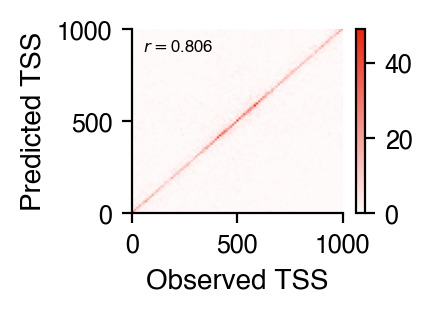

In [ ]:
# DeepDETAILS - initiation
ini_plt_df = pd.concat([sdfs for sdfs in init_details_cors]).sample(5000, random_state=123)

fig = plt.figure(figsize=(1.7, 1.2))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=ini_plt_df[0],
    y=ini_plt_df[1],
    cmap=Reds,
)

ax.text(0.05, 0.95, fr'$r=${np.corrcoef(ini_plt_df[[0, 1]].T)[0, 1]:.3f}', transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left', 
)

fig.colorbar(log_density)
ax.set_xticks((0, 500, 1000))
ax.set_yticks((0, 500, 1000))
ax.set_ylabel("Predicted TSS")
ax.set_xlabel("Observed TSS")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

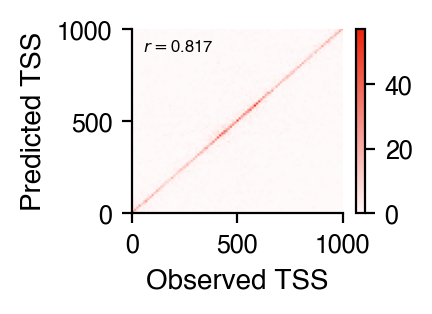

In [ ]:
# Puffin-D - initiation
ref_ini_plt_df = pd.concat([sdfs for sdfs in init_ref_cors]).sample(5000, random_state=123)

fig = plt.figure(figsize=(1.7, 1.2))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=ref_ini_plt_df[0],
    y=ref_ini_plt_df[1],
    cmap=Reds,
)

ax.text(0.05, 0.95, fr'$r=${np.corrcoef(ref_ini_plt_df[[0, 1]].T)[0, 1]:.3f}', transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left', 
)

fig.colorbar(log_density)
ax.set_xticks((0, 500, 1000))
ax.set_yticks((0, 500, 1000))
ax.set_ylabel("Predicted TSS")
ax.set_xlabel("Observed TSS")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

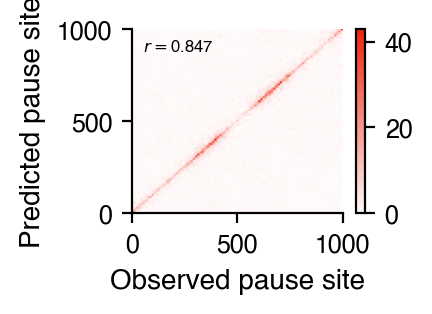

In [ ]:
# DeepDETAILS - pause-release
pr_plt_df = pd.concat([sdfs for sdfs in pr_details_cors]).sample(5000, random_state=123)

fig = plt.figure(figsize=(1.7, 1.2))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=pr_plt_df[0],
    y=pr_plt_df[1],
    cmap=Reds,
)

ax.text(0.05, 0.95, fr'$r=${np.corrcoef(pr_plt_df[[0, 1]].T)[0, 1]:.3f}', transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left', 
)

fig.colorbar(log_density)
ax.set_xticks((0, 500, 1000))
ax.set_yticks((0, 500, 1000))
ax.set_ylabel("Predicted pause site")
ax.set_xlabel("Observed pause site")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

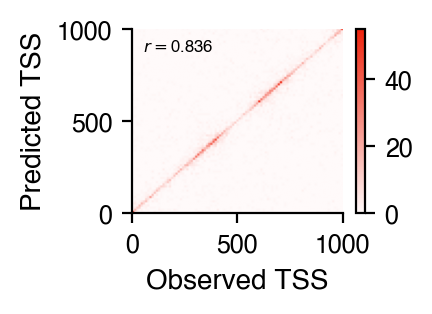

In [ ]:
# Puffin-D - pause-release
ref_pr_plt_df = pd.concat([sdfs for sdfs in pr_ref_cors]).sample(5000, random_state=123)

fig = plt.figure(figsize=(1.7, 1.2))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=ref_pr_plt_df[0],
    y=ref_pr_plt_df[1],
    cmap=Reds
)

ax.text(0.05, 0.95, fr'$r=${np.corrcoef(ref_pr_plt_df[[0, 1]].T)[0, 1]:.3f}', transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left', 
)

fig.colorbar(log_density)
ax.set_xticks((0, 500, 1000))
ax.set_yticks((0, 500, 1000))
ax.set_ylabel("Predicted TSS")
ax.set_xlabel("Observed TSS")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)